In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import skimage.transform
import skimage.measure
from sklearn.neighbors import BallTree
from sklearn.feature_extraction.image import extract_patches_2d
import scipy
from scipy.spatial.distance import euclidean
from scipy.signal import fftconvolve,correlate
import pandas as pd
import pickle
import cv2
from sklearn.preprocessing import OneHotEncoder
from annoy import AnnoyIndex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
ds = 2
lc_path = "downsampled_data"+str(ds)+"/"
naip_path = "downsampled_data_naip"+str(ds)+"/"
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])
def fn(i):
    return paths[i].replace('/','-')[:-7]

def disp(pic):
    plt.figure(figsize=(8,8))
    plt.imshow(pic)
    plt.axis('off')
    plt.show()
    plt.close()

In [15]:
lc = np.load(lc_path+fn(0)+'.npz')['a']
lc2 = np.load(lc_path+fn(1)+'.npz')['a']
print(lc.shape,lc2.shape)

naip = np.load(naip_path+fn(0)+'.npz')['a']
naip = np.rollaxis(naip,0,3)
naip2 = np.load(naip_path+fn(1)+'.npz')['a']
naip2 = np.rollaxis(naip2,0,3)
print(naip.shape,naip2.shape)

(3831, 3093) (3815, 3052)
(3831, 3093, 3) (3815, 3052, 3)


In [16]:
%%time
size = 4
patches = extract_patches_2d(lc,(size,size))
print(patches.shape)
labels, indices,counts = np.unique(patches,axis=0,return_index=True,return_counts=True)
print(labels.shape,indices.shape,counts.shape)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


(11828520, 4, 4)
(785282, 4, 4) (785282,) (785282,)
CPU times: user 1min 10s, sys: 138 ms, total: 1min 10s
Wall time: 1min 10s


In [6]:
%%time
naip_patches = extract_patches_2d(naip2,(size,size))
print(naip_patches.shape)
naip_patches = np.reshape(naip_patches,(-1,3*size**2))
ai = AnnoyIndex(3*size**2)
for idx,i in enumerate(naip_patches):
    ai.add_item(idx,i)
ai.build(25)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


(11622788, 4, 4, 3)
CPU times: user 22min 59s, sys: 11 s, total: 23min 10s
Wall time: 23min 10s


In [7]:
ai.save('annoy_indexes/tile1.ann')

True

In [17]:
%%time
ai = AnnoyIndex(3*size**2)
ai.load('annoy_indexes/tile0.ann')

CPU times: user 810 ms, sys: 2.19 s, total: 3 s
Wall time: 6min 57s


In [30]:
%%time
size = 4
x,y,bigsize = 1500,1500,256
query = naip2#[:-3,:,:]#[x:x+bigsize,y:y+bigsize,:]
print(query.shape)
results = np.zeros((query.shape[0],query.shape[1],7),dtype=int)
for i in range(query.shape[0]-size+1):
    print(str(i)+' ',end='')
    if (i%25==24):
        print('')
    for j in range(query.shape[1]-size+1):
        temp = query[i:i+size,j:j+size,:].flatten()
        #print(j)
        nns = ai.get_nns_by_vector(temp,50)
        temp_results = np.rollaxis(patches[nns],0,3)
        temp_bin = np.zeros((size,size,7),dtype=int)
        for k in range(size):
            for l in range(size):
                temp_bin[k,l] = np.bincount(temp_results[k,l],minlength=7)
        results[i:i+size,j:j+size] += temp_bin
print(results.shape)

(3815, 3052, 3)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 
75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 
125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 
175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 
225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 
250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 

1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 
1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 
1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 
1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 
1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 
1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 
1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 
2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 202

3450 3451 3452 3453 3454 3455 3456 3457 3458 3459 3460 3461 3462 3463 3464 3465 3466 3467 3468 3469 3470 3471 3472 3473 3474 
3475 3476 3477 3478 3479 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489 3490 3491 3492 3493 3494 3495 3496 3497 3498 3499 
3500 3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 
3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 
3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 
3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 
3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 
3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 364

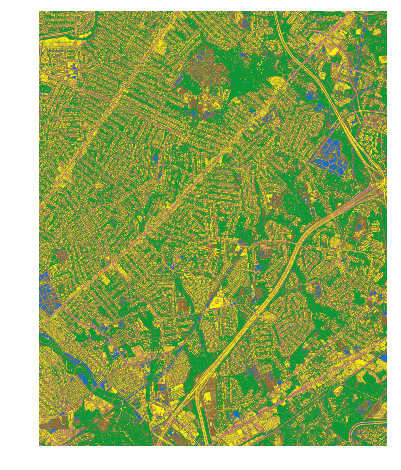

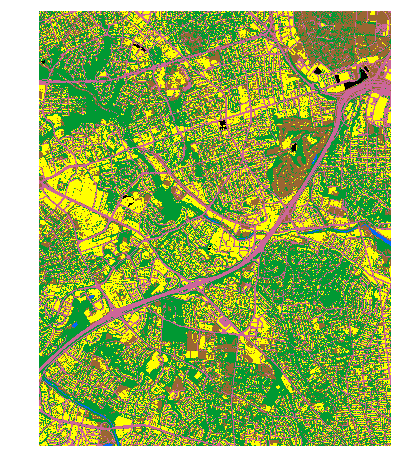

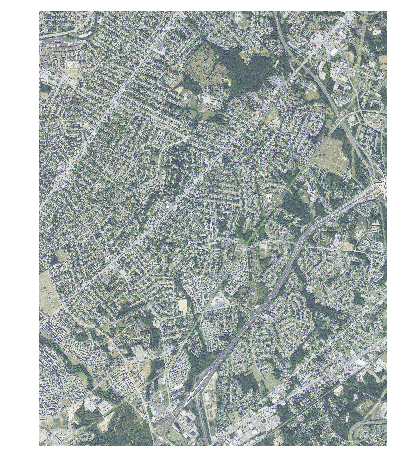

CPU times: user 3min 55s, sys: 2.35 s, total: 3min 57s
Wall time: 3min 55s


In [31]:
%%time
final_image = np.zeros((query.shape[0],query.shape[1],3),dtype=int)
for i in range(results.shape[0]):
    print(str(i)+' ',end='')
        if (i%25==24):
            print('')
    for j in range(results.shape[1]):
        temp = results[i,j]/np.sum(results[i,j])
        temp *= 5
        temp = np.exp(temp)/np.sum(np.exp(temp))
        #print(temp)
        color = np.dot(temp,palette).astype(int)
        final_image[i,j] = color
disp(final_image)
disp(palette[lc2])
disp(query)

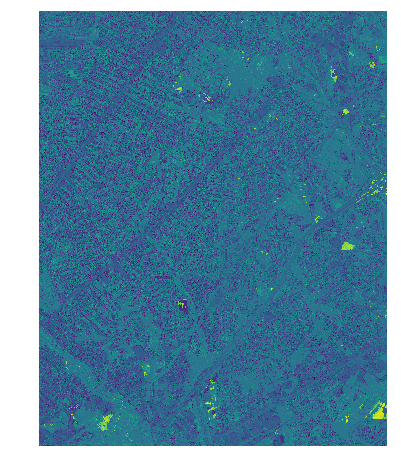

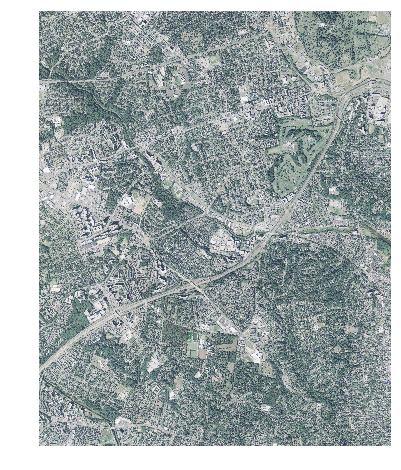

In [32]:
diff = np.sum(final_image-palette[lc2],axis=2)
disp(diff)
disp(naip)

In [37]:
np.sum(diff<10)/(lc.size)

0.6161878317869528

In [7]:
c = rasterio.open("/mnt/blobfuse/esri-naip/"+fn(0).replace('-','/')+".mrf",'r')
naip = c.read()[:3,:,:]
naip = np.rollaxis(naip,0,3)
c.close()
print(naip.shape)

(7662, 6185, 3)


In [17]:
patches = extract_patches_2d(naip,(8,8))

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides
